In [83]:
from casperfpga import CasperFpga
from struct import *
import matplotlib.pyplot as plt
import numpy as np

In [28]:
%matplotlib inline

In [5]:
snap = CasperFpga("192.168.0.3")

In [7]:
# Teach CasperFPGA about the design that's running
fpg = "grex_gateware.fpg"
snap.get_system_information(fpg,initialise_objects=False)

## Raw ADC

In [53]:
# Grab ADC data
snap.snapshots['adc_snap'].arm()
snap.write_int("adc_snap_trig", 1)
snap.write_int("adc_snap_trig", 0)
adc_data = snap.snapshots['adc_snap'].read()['data']['data']

In [58]:
# Each word from the ADC snapshot is a[N]a[N+1]b[N]b[N+1], signed 8 bit integer
def deinterleave_adc(raw_adc_snap):
    n = len(raw_adc_snap) * 2
    a = np.zeros(n, dtype=np.int8)
    b = np.zeros(n, dtype=np.int8)
    for i, samp in enumerate(raw_adc_snap):
        a[2*i+0] = np.uint8((samp >> 24) & 0xFF)
        a[2*i+1] = np.uint8((samp >> 16) & 0xFF)
        b[2*i+0] = np.uint8((samp >> 8) & 0xFF)
        b[2*i+1] = np.uint8(samp & 0xFF)
    return a,b

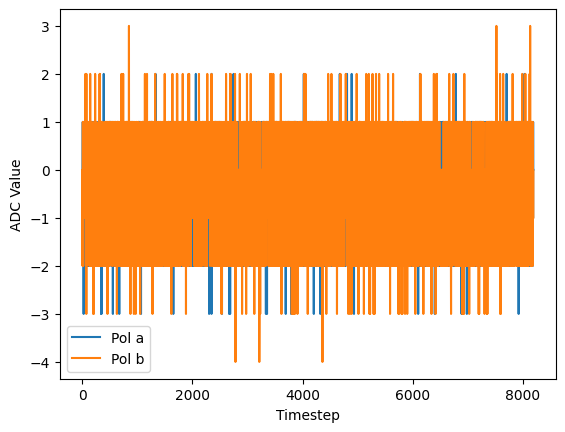

In [128]:
a,b = deinterleave_adc(adc_data)
plt.plot(a, label='Pol a')
plt.plot(b, label='Pol b')
plt.ylabel("ADC Value")
plt.xlabel("Timestep")
plt.legend()

## Pre-Requant Integrations

In [114]:
freq = np.linspace(1530,1280,num=2048)

In [116]:
int_n = 8192
snap.write_int('spec_vacc_n', int_n) # Total number of samples to integrate
snap.write_int("spec_vacc_trig", 1) # Rising edge trigger
snap.write_int("spec_vacc_trig", 0)

In [117]:
pra = np.array(unpack('>2048Q', snap.devices['spec_a_vacc'].read_raw()[0])) / int_n
prb = np.array(unpack('>2048Q', snap.devices['spec_b_vacc'].read_raw()[0])) / int_n

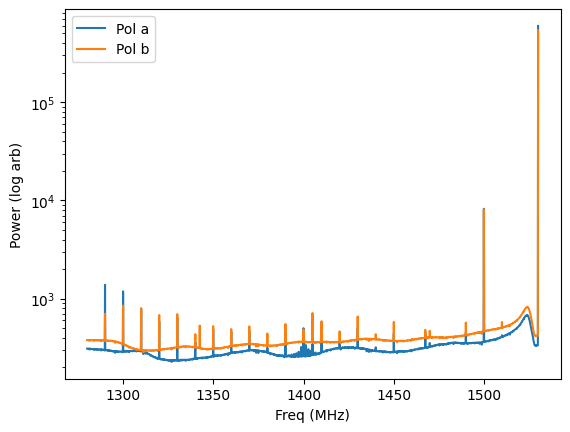

In [131]:
plt.plot(freq, pra, label='Pol a')
plt.plot(freq, prb, label='Pol b')
plt.yscale('log')
plt.ylabel("Power (log arb)")
plt.xlabel("Freq (MHz)")
plt.legend()

## Post-Requant Integration

In [123]:
snap.write_int('stokes_vacc_n', int_n) # Total number of samples to integrate
snap.write_int("stokes_vacc_trig", 1) # Rising edge trigger
snap.write_int("stokes_vacc_trig", 0)

In [125]:
stokes = np.array(unpack('>2048Q', snap.devices['stokes_vacc'].read_raw()[0])) / int_n

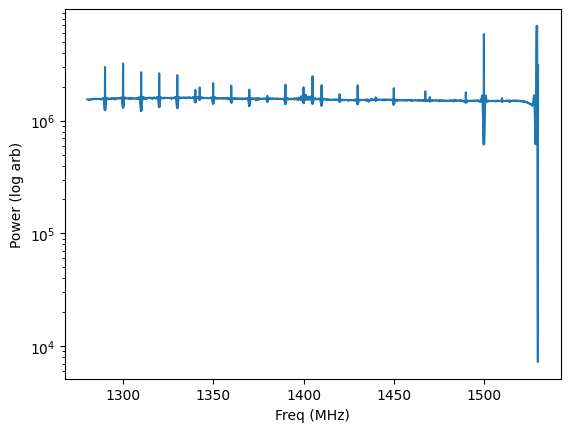

In [130]:
plt.plot(freq, stokes)
plt.ylabel("Power (log arb)")
plt.xlabel("Freq (MHz)")
plt.yscale('log')